In [2]:
import sys
import glob
import torch
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
import slice_data_h5 as sdl_h5
transforms1 = Compose(
    [
     AddChanneld(('image','label')),
     Orientationd(('image','label'),'RAS'),
#      Spacingd(('image','label'),(1,1,1)),        
     Resized(keys = ('image'),spatial_size = (128, 128,-1),mode = 'trilinear' ,align_corners = True),
     Resized(keys = ('label'),spatial_size = (128, 128,-1),mode = 'nearest' ),
     ScaleIntensityD(('image',)),
     ToTensord(('image','label')),
    ]
)



In [14]:
import os
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
import threading

class H5CachedDataset(Dataset):
    def __init__(self, niilist,masklist,
                 transforms_offline, transforms_online=ToTensord(('image',)),
                 nslices_per_image = 155 ,
                 start_slice = 10,
                 end_slice = 10,
                 h5cachedir=None):
        #### nslices_per_image ---> total slice in the volume
        #### h5cachedir ---> directory to save one .h5 files for each volume & it would act like a cache directory
        #### if h5cachedir does not exist create one 

#         self.lock = threading.Lock()
        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir
#             print(self.cachedir)
        #### datalist ---> a list [{'image': volume_1_path},......,{'image': volume_n_path}]
        #### masklist ---> a list [{'mask': mask_1_path},......,{'image': mask_n_path}]
        self.datalist = niilist
        self.masklist = masklist
#         print(f'length of datalist {len(niilist)}')
#         print(f'length of masklist {len(masklist)}')
        self.xfms = transforms_offline
        self.xfms2 = transforms_online
        #### 3d image loader from monai
        self.loader = LoadImage()
        self.loader.register(NibabelReader())  
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        self.start_slice = start_slice
        self.end_slice = end_slice
        #### nslices ---> nslices_per_image - end_slice i.e. slice value after end truncation
        #            ---> nslices is kept flexible so that index is obtained by adding front truncation value &
        #            ---> total length of the loder is caluclated considering subtracting front truncation value
        self.nslices = nslices_per_image - self.end_slice
#         print(self.nslices)
        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
        #### index can take values from 
                # 0 to (total number of volumes * (len(datalist)*(nslices - start_slice)))  
        #### filenum can take values from 0 to total number of volumes (0-369)
        #### slicenum can take values from 0 to (len(datalist)*(nslices - start_slice))
        filenum = index // (self.nslices - self.start_slice)
#         print(f'self.nslices - self.start_slice {self.nslices - self.start_slice}\n')
#         print(f'index {index}\n')
#         print(f'filenum {filenum}\n')
        slicenum = index % (self.nslices - self.start_slice)
#         print(f'slicenum {slicenum}')
        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum
        datalist_filenum = self.datalist[filenum]
        loc_data = datalist_filenum['image']  ###path to image
        masklist_filenum = self.masklist[filenum]
        loc_mask = masklist_filenum['label'] ### path to label
        
        


        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum
#             print(h5name)
            ptname = self.cachedir+'/%d.pt' % filenum

            if os.path.exists(h5name):
                
                with h5py.File(h5name,'r',libver='latest', swmr=True) as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])
                data['image_meta_dict']={'affine':np.eye(3)} # FIXME: loses spacing info - can read from pt file


        ##### if data dictionary is empty
        if len(data)==0:
            #### Read image & mask data, meta data
            imgdata, meta = self.loader(loc_data)  
            mask_data, mask_meta = self.loader(loc_mask)
            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'image':imgdata,'label':mask_data, 'image_meta_dict':meta, 'label_meta_dict':mask_meta}
#             print(imgdata.shape) (240*240*155)
            #### transform the data dictionary
            data3d = self.xfms(data_i)
#             print(data3d.keys())
#             print(data3d['image'].shape)
            #### Create h5 file for the volume by chunking into the slice shape for data & mask 
            #### Create a .pt file for meta data
            if self.cachedir is not None:
                other = {}

                with h5py.File(h5name,'w',libver='latest') as itm:
                    itm.swmr_mode = True
                    for key in data3d:
                        if key=='image' or key=='label':                             
                            img_npy = data3d[key].numpy()
                            if key == 'label':
                                img_npy = (img_npy>0).astype('uint8')
                            shp = img_npy.shape
                            
                            chunk_size = list(shp[:-1])+[1]
#                             print(chunk_size)
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
#                             print('ds shape',ds.shape)
                            ds.flush()
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)

            print(data3d['image'].shape)
            #### fill the data dictionary
#             print(f'slicenum {slicenum}')
#             print(f'filenum {filenum}')
            data = {
                'image':data3d['image'][:,:,:,slicenum],
                'label':data3d['label'][:,:,:,slicenum],
                'image_meta_dict':{
                    'affine':np.eye(3)
                }
            }

            
        if len(data)>0:
#             print("**",data.keys())
#             res = self.xfms2(data)
            res = data
            res['image']=res['image'].float()
            res['label']=res['label'].to(torch.int64)
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            return res

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [15]:
brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_t1ce.nii'
brats_mask = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
datalist = [{'image':x} for x in glob.glob(brats_datapath)]
masklist = []
for x in glob.glob(brats_mask):
    if (x.split('/')[8].split('_')[-1]== 'seg.nii'):
        masklist.append({'label': x})
        
h5cachedir_ = '/srv/Data/playground_data/brats/brats_training_data/h5_data'                                                                
h5cacheds = H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)

In [16]:
d =h5cacheds.__getitem__(5)

In [17]:

brats_datapath = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_t1ce.nii'
brats_mask = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_seg.nii'
datalist = [{'image':x} for x in glob.glob(brats_datapath)]
masklist = []
for x in glob.glob(brats_mask):
    if (x.split('/')[8].split('_')[-1]== 'seg.nii'):
        masklist.append({'label': x})
        
h5cachedir_ = '/srv/Data/playground_data/brats/brats_training_data/h5_data'                                                                
h5cacheds = H5CachedDataset(datalist,masklist,transforms1,h5cachedir=h5cachedir_)
torch.multiprocessing.set_sharing_strategy('file_system')
brats_loader = torch.utils.data.DataLoader(h5cacheds,batch_size = 5 ,\
                                           shuffle = True,num_workers= 1)# ,pin_memory = True)


In [18]:
import matplotlib.pyplot as plt
for idx, data in enumerate(brats_loader):
    image=data['image']
    label=data['label']
    break
   

(1, 128, 128, 155)


In [7]:
path='/srv/Data/playground_data/brats/brats_training_data/data_raw/'
sorted(glob.glob("%s/**/**_t1.nii" % path))

['/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_001/BraTS20_Training_001_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_002/BraTS20_Training_002_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_003/BraTS20_Training_003_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_004/BraTS20_Training_004_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_005/BraTS20_Training_005_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_006/BraTS20_Training_006_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_007/BraTS20_Training_007_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_008/BraTS20_Training_008_t1.nii',
 '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_009/BraT

In [19]:
image.shape

(5, 1, 128, 128)

In [20]:
image.shape

(5, 1, 128, 128)

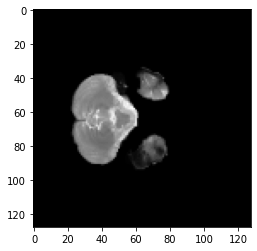

In [21]:
plt.imshow(image[3].squeeze(0),cmap='gray')